# Data Wrangling with Mongo DB -- OpenStreetMap

## Background

Choose any area of the world from https://www.openstreetmap.org, and download a XML OSM dataset. The dataset should be at least 50MB in size (uncompressed). Thoroughly audit and clean your dataset, converting it from XML to JSON format. Then import the cleaned .json file into a MongoDB database. After building your local database you’ll explore your data by running queries.

### Dataset

We choose the area of Vancouver, BC, Canada, which sits west of Canada and is one of the most crowded cities in Canada. The osm dataset is 181.4MB. We take a systematic sample of elements from the original OSM region by using the code provided in the project details to do the initial data auditing and analysis. The whole dataset is then analyzed by the final project code. 

The dataset is downloaded from <https://mapzen.com/data/metro-extracts/metro/vancouver_canada/>

### The City of Vancouver

<https://en.wikipedia.org/wiki/Vancouver>

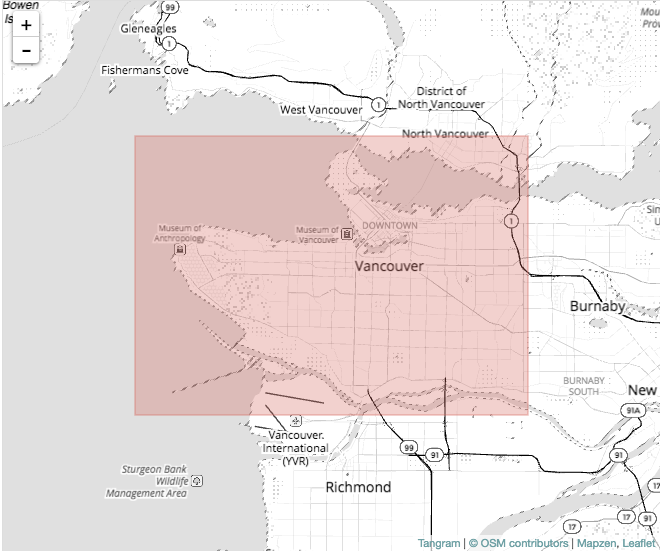

In [1]:
from IPython.display import Image
Image("Vancouver.png")

## Audit and Clean Dataset

### Problems Encountered in the Map

Before investigating the whole dataset, we select a sample dataset to initially review the data. We encountered the following five problems with the data:

* Abbreviated street names (St. for Street, Ave for Avenue, etc.)
* Multiple abbreviated street names (W Cordova St, W Hastings St #360, etc.)
* Typo in street names (West Hastings Steet, Greer Venue)
* Inconsistent format in street names (Howe St. Vancouver => Howe Street)
* Inconsistent and incorrect postal code (See results below)

#### Abbreviated street names

Example: St. for Street, Ave for Avenue

The mapping dictionary has been updated to map abbreviated street names to the original words.

#### Multiple abbreviated street names

Example: W Cordova St => West Cordova Street,  W Hastings St #360 => West Hastings Street #360

The mapping dictionary and update_name method have been updated to map abbreviated street names to the original words.

#### Typo in street names

Example: West Hastings Steet => West Hastings Street, Greer Venue => Greer Avenue

When investigating the whole dataset, we found two typos in street names. Each problem has been fixed by changing the mapping dictionary and update_name method.

#### Inconsistent format in street names

Example: Howe St. Vancouver, W. Hastings St. Vancouver

By searching in Google map, the above street names are Howe Street and West Hastings Street. The last word Vancouver indicates the city. However, only two instances were found ending with the city name. Generally, street names do not end with city name. Therefore, we fixed the two street names to the names in common format.

We updated the regular expression "street_type_re" to identify the two instances and fixed them by changing the update_name method.


#### Code snippets to audit street names

In [ ]:
import xml.etree.cElementTree as ET
import pprint
import re
import codecs
import json

street_type_re = re.compile(r'\b\S+\.?$|St. Vancouver', re.IGNORECASE)
street_end_with_number_re = re.compile(r'\d+$')

expected = ["Street", "Avenue", "Boulevard", "Drive", "Court", "Place", "Square", "Lane", "Road",
            "Trail", "Parkway", "Commons", "Broadway", "Kingsway", "Way", "West", "Crescent", "East",
            "North", "South", "Connector", "Jarvis", "Highway", "Mews", "Alley", "Mall", "Walk",
            "Esplanade", "Jervis", "Nanaimo", "Pender", "Terminal", "Broughton"]

mapping = { " St\.": "Street",
            "Ave": "Avenue",
            "Rd\.": "Road",
            " St": "Street",
            "Blvd": "Boulevard",
            "Steet": "Street",
            " Venue": " Avenue",
            "W ": "West ",
            "Denmanstreet": "Denman Street",
            " E": " East",
            " street": " Street",
            "W\. ": "West ",
            " W\.": " West",
            " W": "West"
        }

special_keys = [" St\.", " St", " W"]

def audit_street_type(street_name):
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group()
        if street_type not in expected:
            return update_name(street_name, mapping)
    return street_name


def is_street_name(address_key):
    return (address_key == "addr:street")

# The method has been updated to deal with cases occurred in our dataset
def update_name(name, mapping):
    # when "st" is in the middle of the street name
    if " St " in name:
        name = re.sub(" St ", " Street ", name)
    
    for key in mapping.iterkeys():
        if re.search(key, name):
            if key in special_keys:
                # if street name ends with number
                # e.g. W Hastings St #360
                if street_end_with_number_re.search(name):
                    continue
                else:
                    name = re.sub(street_type_re, mapping[key], name)
            else:
                name = re.sub(key, mapping[key], name)
                if key == " Venue":
                    break

    return name


#### Inconsistent and incorrect postal code

Postal code is an important part of an address. Canadian postal codes have strict format and should be corrected carefully. We use regular expression to identify problematic or invalid postal codes in the dataset. Specifically, Canadian postal codes consists of six characters and both letters and numbers are used in the format. Upper or lower case of letters in postal codes are acceptable. Space or no space between the first three characters and the last three characters are acceptable. We use the regex from <http://howtodoinjava.com/regex/java-regex-validate-canadian-postal-zip-codes/> in the python code.

After investigating the whole dataset, we found the following problematic or invalid postal codes:

~~~
 'V53 3H9'          -- Invalid
 'V6'               -- Invalid
 'BC V6B 2E2'       -> to -> V6B 2E2
 'BC V6R 1P2'       -> to -> V6R 1P2
 'V6C OC3'          -> to -> V6C 0C3
 'V5T-4T1;V5T 4T1'  -> to -> V5T 4T1
 'V5Z'              -- Invalid
 'V6C'              -- Invalid
 'V5P 3W7,'         -> to -> V5P 3W7
 'V5P 3W7,'         -> to -> V5P 3W7
 'V5Z'              -- Invalid
 'V6HH 2R5'         -> to -> V6H 2R5
 'V5W 0A'           -- Invalid
 '5368'             -- Invalid
 'V5N5H7 '          -> to -> V5N5H7
~~~

We fixed the problematic postal codes. In order to fix the invalid postal codes, more information about the location is needed.

#### Code snippets to audit postal codes

In [ ]:
post_codes = re.compile(r'^(?!.*[DFIOQU])[A-VXY][0-9][A-Z] ?[0-9][A-Z][0-9]$', re.IGNORECASE)

def audit_postcode(postcode):
    postcode = postcode.upper()
    m = post_codes.match(postcode)
    if m:
        return postcode
    else:
        # Correct postal code
        if "BC " in postcode:
            postcode = postcode[3:]
        elif "OC" in postcode:
            postcode = postcode.replace("OC", "0C")
        elif "V5T" in postcode:
            postcode = postcode[8:]
        elif "," in postcode:
            postcode = postcode[:7]
        elif "6HH" in postcode:
            postcode = postcode.replace("6HH", "6H")
        elif "V5N5H7 " in postcode:
            postcode = postcode[:6]

    return postcode

def is_postcode(postcode_key):
    return (postcode_key == "addr:postcode")

### Import to MongoDB

We use mongoimport to import our json file to MongoDB.

mongoimport --db udacity --collection open_street_map --drop --file vancouver.osm.json


## Data Overview

This section contains basic statistics about the dataset and the MongoDB queries used to gather them.

#### File sizes:

vancouver.osm: 181.4 MB

vancouver.osm.json: 210.2 MB

#### Overview:

db.stats()

~~~
    "db" : "udacity",
	"collections" : 1,
	"views" : 0,
	"objects" : 955380,
	"avgObjSize" : 236.86043040465574,
	"dataSize" : 226291718,
	"storageSize" : 68247552,
	"numExtents" : 0,
	"indexes" : 1,
	"indexSize" : 8499200,
	"ok" : 1
~~~

#### Number of documents:

db.getCollection('open_street_map').find().count()

955380

#### Number of nodes:

db.getCollection('open_street_map').find({"type": "node"}).count()

800865

#### Number of ways:

db.getCollection('open_street_map').find({"type": "way"}).count()

154494

#### Number of unique users:

db.getCollection('open_street_map').distinct("created.user").length

783

#### Top 1 contributing user:

~~~
db.open_street_map.aggregate([
    {"$group":{"_id":"$created.user", "count":{"$sum":1}}}, 
    {"$sort":{"count":-1}}, 
    {"$limit":1}])
~~~
~~~
{ "_id" : "keithonearth", "count" : 332705 }  
~~~

#### Top 10 contributing users:

~~~
db.open_street_map.aggregate([
    {"$group":{"_id":"$created.user", "count":{"$sum":1}}}, 
    {"$sort":{"count":-1}}, 
    {"$limit":10}])
~~~
~~~
{ "_id" : "keithonearth", "count" : 332705 }
{ "_id" : "michael_moovelmaps", "count" : 113227 }
{ "_id" : "still-a-worm", "count" : 97613 }
{ "_id" : "treeniti2", "count" : 75012 }
{ "_id" : "pdunn", "count" : 41962 }
{ "_id" : "muratc3", "count" : 37159 }
{ "_id" : "WBSKI", "count" : 31776 }
{ "_id" : "rbrtwhite", "count" : 22144 }
{ "_id" : "Siegbaert", "count" : 21405 }
{ "_id" : "pnorman", "count" : 20035 }
~~~

#### Number of users appearing only once (having 1 post):

~~~
db.open_street_map.aggregate([
    {"$group":{"_id":"$created.user", "count":{"$sum":1}}}, 
    {"$group":{"_id":"$count", "num_users":{"$sum":1}}}, 
    {"$sort":{"_id":1}}, 
    {"$limit":1}])
~~~
~~~ 
{ "_id" : 1, "num_users" : 250 }
~~~
Note: “_id” represents postcount

#### Top 10 appearing amenities:

~~~
db.open_street_map.aggregate([
    {"$match": {"amenity": {"$exists": 1} }},
    {"$group": {"_id": "$amenity", "count": {"$sum": 1}}},
    {"$sort": {"count": -1}},
    {"$limit": 10}
])
~~~
~~~
{ "_id" : "parking", "count" : 1121 }
{ "_id" : "restaurant", "count" : 734 }
{ "_id" : "bench", "count" : 721 }
{ "_id" : "cafe", "count" : 398 }
{ "_id" : "bicycle_parking", "count" : 395 }
{ "_id" : "fast_food", "count" : 334 }
{ "_id" : "post_box", "count" : 228 }
{ "_id" : "bank", "count" : 156 }
{ "_id" : "school", "count" : 145 }
{ "_id" : "toilets", "count" : 118 }
~~~

#### Top religions:

~~~
db.open_street_map.aggregate([
    {"$match": {"amenity": {"$exists": 1}, "amenity":"place_of_worship"}},
    {"$group": {"_id": "$religion", "count": {"$sum": 1}}},
    {"$sort": {"count": -1}},
    {"$limit": 10}
])
~~~
~~~
{ "_id" : "christian", "count" : 84 }
{ "_id" : null, "count" : 7 }
{ "_id" : "buddhist", "count" : 5 }
{ "_id" : "sikh", "count" : 2 }
{ "_id" : "jewish", "count" : 2 }
{ "_id" : "taoist", "count" : 2 }
{ "_id" : "muslim", "count" : 1 }
{ "_id" : "bahai", "count" : 1 }
~~~

We can see from the results that, for some "place_of_worship", we don't know the religion information.

#### Most popular cuisines:

~~~
db.open_street_map.aggregate([
    {"$match": {"amenity": {"$exists": 1}, "amenity":"restaurant"}},
    {"$group": {"_id": "$cuisine", "count": {"$sum": 1}}},
    {"$sort": {"count": -1}},
    {"$limit": 10}
])
~~~
~~~
{ "_id" : null, "count" : 344 }
{ "_id" : "japanese", "count" : 51 }
{ "_id" : "chinese", "count" : 49 }
{ "_id" : "sushi", "count" : 31 }
{ "_id" : "vietnamese", "count" : 20 }
{ "_id" : "pizza", "count" : 17 }
{ "_id" : "italian", "count" : 14 }
{ "_id" : "indian", "count" : 14 }
{ "_id" : "thai", "count" : 13 }
{ "_id" : "mexican", "count" : 11 }
~~~

Large number of restaurants have no cuisine information. The above results cannot show correct cuisine popularity.

#### Top cafes:

~~~
db.open_street_map.aggregate([
    {"$match": {"amenity": {"$exists": 1}, "amenity":"cafe"}},
    {"$group": {"_id": "$name", "count": {"$sum": 1}}},
    {"$sort": {"count": -1}},
    {"$limit": 10}
])
~~~
~~~
{ "_id" : "Starbucks", "count" : 74 }
{ "_id" : "Starbucks Coffee", "count" : 19 }
{ "_id" : "Blenz Coffee", "count" : 16 }
{ "_id" : "Tim Hortons", "count" : 15 }
{ "_id" : null, "count" : 14 }
{ "_id" : "JJ Bean", "count" : 8 }
{ "_id" : "Blenz", "count" : 7 }
{ "_id" : "Caffè Artigiano", "count" : 3 }
{ "_id" : "Waves Coffee", "count" : 3 }
{ "_id" : "Waves Coffee House", "count" : 3 }
~~~

"Starbucks" and "Starbucks coffee" refer to the same cafe. It is surprising to me that the Starbucks have 6.2 times more stores than Tim Hortons in Vancouver. The latter dominates the Canadian cafe markets almost all over the country. So I suspect there is something wrong with the number of Tim Hortons, the following queries are executed to further investigate.

#### Top fast food:

~~~
db.open_street_map.aggregate([
    {"$match": {"amenity": {"$exists": 1}, "amenity":"fast_food"}},
    {"$group": {"_id": "$name", "count": {"$sum": 1}}},
    {"$sort": {"count": -1}},
    {"$limit": 10}
])
~~~
~~~
{ "_id" : "Subway", "count" : 45 }
{ "_id" : "McDonald's", "count" : 23 }
{ "_id" : "A&W", "count" : 12 }
{ "_id" : "Tim Hortons", "count" : 12 }
{ "_id" : null, "count" : 8 }
{ "_id" : "Wendy's", "count" : 5 }
{ "_id" : "Church's Chicken", "count" : 4 }
{ "_id" : "Fresh Slice", "count" : 4 }
{ "_id" : "Vera's Burger Shack", "count" : 4 }
{ "_id" : "Quiznos", "count" : 3 }
~~~

As we can see, Tim Hortons are categorized to fast food for some entries. In order to get the correct number of Tim Hortons, we did the following query.

#### Number of Tim Hortons:

~~~
db.open_street_map.aggregate([
    {"$match": {"name": "Tim Hortons"}},
    {"$group": {"_id": "$name", "count": {"$sum": 1}}}
])
~~~
~~~
{ "_id" : "Tim Hortons", "count" : 27 }
~~~

Now we see that the total number of Tim Hortons is 27, which is still much smaller than that of the Starbucks. Therefore, I did some search online and found the page <http://www.bcbusiness.ca/why-vancouver-is-the-only-market-tim-hortons-hasnt-cracked>. The Starbucks do have more stores than Tim Hortons in Vancouver and the article discussed the reason. Based on what I have found online, the results from our queries are acceptable.

## Additional Ideas

In order to improve the data analysis process, some validation filters can be added to the users input process. 

One suggestion is for postal codes validation. Since postal codes usually have strong structure, pre-defined format can be added to the user input. In this way, it is easier to make sure that the postal codes in the dataset follow correct format, so that we don't need to worry about the inconsistency and incorrect postal codes when conducting data analysis. However, there are several problems with this suggestion.

* Different postal codes format for different areas. Although we know that Canadian postal codes have strict format, some areas can have flexible postal codes format and different areas have different rules on postal codes. The pre-defined format has to be carefully designed for different areas. It requires large amount of knowledge about postal codes all over the world. Otherwise, users may tend to input valid but incorrect postal codes. 
* Users may not know the postal codes. Not all users know the postal codes of their entry. With the pre-defined format of postal codes, we still cannot make sure that all the postal codes are correct. Even in our analysis in this project, we only checks the format of the postal codes and we cannot know if the postal codes are actually correct without digging into the data further.

Another suggestion is to use GPS information to help find correct postal codes format. Again, it requires knowledge about postal codes for different areas. The problems discussed above may still exist.

To improve the data analysis process of street names, recommended street names can be provided based on users input before the system accepting the addresses. For example, when we make purchases through Amazon.com, the system will automatically give us recommended addresses based on our input and the recommended addresses usually follow some pre-defined format. The OpenStreetMap can follow the same idea so that less effort is needed when we process addresses. The problem of this sugguestion is that a lot of work may be needed to design and implement the user input process. It may be too much work for an open source project. Also, it is hard to manage addresses in different languages since the OpenStreetMap covers different areas using different languages. 

## References

* <https://www.tutorialspoint.com/mongodb/index.htm>
* <http://howtodoinjava.com/regex/java-regex-validate-canadian-postal-zip-codes/>
* <https://en.wikipedia.org/wiki/OpenStreetMap>
* <https://mapzen.com/data/metro-extracts/>
* <http://wiki.openstreetmap.org/wiki/OSM_XML>
* <https://docs.mongodb.com/manual/>